# Dog Breed Classifier with HPO/Debugging/Profiling

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [3]:
# DONE: Install any packages that you might need
!pip install smdebug

In [4]:
# DONE: Import any packages that you might need
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()

# bucket = sagemaker_session.default_bucket()
bucket = 'edgarin-mlend'
prj_prefix = 'prj-dogbreed'
data_prefix = f"{prj_prefix}/dogImages"
data_s3_uri = f"s3://{bucket}/{data_prefix}"

role = sagemaker.get_execution_role()
data_s3_uri

's3://edgarin-mlend/prj-dogbreed/dogImages'

## DatasHyperparameterTunerDO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#DONE: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [4]:
sagemaker_session.upload_data('./dogImages.zip', bucket=bucket, key_prefix=prj_prefix)
# The unzipping is done with Lambda separately

's3://edgarin-mlend/prj-dogbreed/dogImages.zip'

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

#### Test the train script in isolation

In [2]:
!SM_HOSTS='[]' SM_CURRENT_HOST='' SM_MODEL_DIR='./model' SM_CHANNEL_TRAIN='./dogImages-express/valid' SM_CHANNEL_TEST='./dogImages-express/test' SM_NUM_GPUS=1  python3 train_model.py --batch-size 64 --test-batch-size 64 --epochs 1 --lr 0.003

ALL ARGS:  Namespace(batch_size=64, current_host='', epochs=1, hosts=[], lr=0.003, model_dir='./model', num_gpus=1, test_batch_size=64, test_dir='./dogImages-express/test', train_dir='./dogImages-express/valid')
Start training...
[2022-01-20 02:25:06.092 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:322 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-20 02:25:06.395 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:322 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
  Epoch 1.. Epoch progress: 0.0%.. Batch avg train loss: 0.076.. 
  Epoch 1.. Epoch progress: 71.4%.. Batch avg train loss: 0.076.. 
Epoch 1.. Progress: 0.0% Train loss: 0.083 Test loss: 0.075 Test accuracy: 0.143
Final test accuracy: 0.143
done


In [3]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

# DONE: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'batch-size': CategoricalParameter([128, 256]),
    'lr': ContinuousParameter(0.001, 0.01),
    'epochs': IntegerParameter(2, 5),
}

objective_metric_name = "Average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Average test accuracy", "Regex": "Test accuracy: ([0-9\\.]+)"}]



In [23]:
# DONE: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

# DONE: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    #instance_type='ml.p3.2xlarge',  
)

# DONE: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=16,
    max_parallel_jobs=4,
    objective_type=objective_type
)

In [6]:
# DONE: Fit your HP Tuner
# # s3://edgarin-mlend/prj-dogbreed/dogImages/
predictor = tuner.fit({
    'train': f'{data_s3_uri}/train',
    'test': f'{data_s3_uri}/test',
}) # DONE: Remember to include your data channels

....................................................


In [5]:
# To get the tuner 'offline' (another notebook session)
tuner = HyperparameterTuner.attach('pytorch-training-220120-0318')

In [7]:
# DONE: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-20 08:34:15 Starting - Preparing the instances for training
2022-01-20 08:34:15 Downloading - Downloading input data
2022-01-20 08:34:15 Training - Training image download completed. Training in progress.
2022-01-20 08:34:15 Uploading - Uploading generated training model
2022-01-20 08:34:15 Completed - Training job completed


{'_tuning_objective_metric': '"Average test accuracy"',
 'batch-size': '"128"',
 'epochs': '5',
 'lr': '0.002528913920826402',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-01-20-03-18-30-959"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-784712499272/pytorch-training-2022-01-20-03-18-30-959/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [5]:
# DONE: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    # Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    # Rule.sagemaker(rule_configs.overtraining()),
    # Rule.sagemaker(rule_configs.poor_weight_initialization()),
    # Rule.sagemaker(rule_configs.loss_not_decreasing()),    
    # ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

# create the profiler and debugger configs
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10)
)
debugger_config = DebuggerHookConfig(
    hook_parameters={
        'train.save_internal': '1', # Was 10
        'eval.save_internal': '1'
    },
    collection_configs=[
        # CollectionConfig(name="weights"),
        # CollectionConfig(name="gradients"),
        CollectionConfig(name="losses"),
        # CollectionConfig(name="biases")
    ]
)

In [7]:
# Got values from HPO
best_hyperparameters = {
    'batch-size': 128,
    'epochs': 5,
    'lr': 0.0025
}
best_hyperparameters = {
    'batch-size': 64,
    'epochs': 2,
    'lr': 0.0025
}

In [ ]:
# DONE: Create and fit an estimator
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
  base_job_name='prj-dogbreed-trjob',
  role=sagemaker.get_execution_role(),
  instance_type='ml.m5.large',    
  #instance_type='ml.p3.2xlarge',
  instance_count=1,
  entry_point='./train_model.py',
  framework_version='1.8',
  py_version='py36',
  hyperparameters=best_hyperparameters,  
  rules=rules,
  debugger_hook_config=debugger_config,
  profiler_config=profiler_config  
)

estimator.fit({
    'train': f'{data_s3_uri}/valid',
    'test': f'{data_s3_uri}/test',
}, wait=True)

2022-01-22 01:07:43 Starting - Starting the training job...

In [ ]:
# estimator = PyTorch.attach('prj-dogbreed-trjob-2022-01-21-20-07-42-574', sagemaker_session)

In [ ]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial

In [ ]:
trial.tensor_names()

In [ ]:
loss_tensor_name = "NLLLoss_output_0"
train_datapoints = len(trial.tensor(loss_tensor_name).steps(mode=ModeKeys.TRAIN))
eval_datapoints = len(trial.tensor(loss_tensor_name).steps(mode=ModeKeys.EVAL))
print(train_datapoints, eval_datapoints)

In [ ]:
for tensor_name in trial.tensor_names():
    train_datapoints = len(trial.tensor(tensor_name).steps(mode=ModeKeys.TRAIN))
    eval_datapoints = len(trial.tensor(tensor_name).steps(mode=ModeKeys.EVAL))
    print(tensor_name, train_datapoints, eval_datapoints)

In [63]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


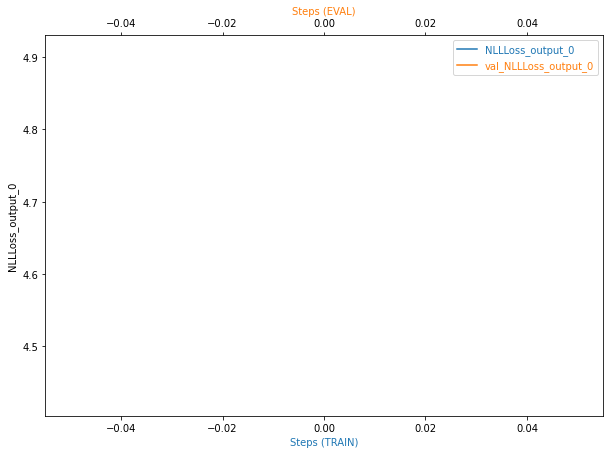

In [22]:
plot_tensor(trial, loss_tensor_name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Profiling

In [29]:
# TODO: Display the profiler output
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

training_job_name = estimator.latest_training_job.job_name

tj = TrainingJob(training_job_name, region = sagemaker_session.boto_region_name)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-784712499272/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/profiler-output


Profiler data from system is available


In [30]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2022-01-21 16:00:13.073 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:38 INFO metrics_reader_base.py:134] Getting 28 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1'}


In [31]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output


In [32]:
! aws s3 ls {rule_output_path} --recursive

2022-01-21 15:55:35     364853 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-21 15:55:35     211916 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-21 15:55:31        192 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-21 15:55:31        200 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-21 15:55:31       2029 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-21 15:55:31        127 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-21 15:55:31        199 prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-outp

In [33]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-784712499272/prj-dogbreed-trjob-2022-01-21-15-25-56-908/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-78471249927

In [ ]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()